In [80]:
import numpy as np

import matplotlib.pyplot as plt

from astropy.time import Time
import astropy.units as u

import photutils

from fass.ser import load_ser_file
from fass.analyze_cube import find_apertures, moments, seeing, analyze_dimm_cube

In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

In [2]:
testfile = "/home/tim/MMT/FASS/data/indi_2022-08-29/indi_record_2022-08-29@05-11-47.ser"
d = load_ser_file(testfile)

/home/tim/conda/envs/fass/lib/python3.10/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "dtf2d" yielded 1 of "dubious year (Note 6)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/home/tim/conda/envs/fass/lib/python3.10/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/home/tim/conda/envs/fass/lib/python3.10/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),


/home/tim/conda/envs/fass/lib/python3.10/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "dtf2d" yielded 1 of "dubious year (Note 6)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/home/tim/conda/envs/fass/lib/python3.10/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/home/tim/conda/envs/fass/lib/python3.10/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),


<Quantity 1.97876568 arcsec>

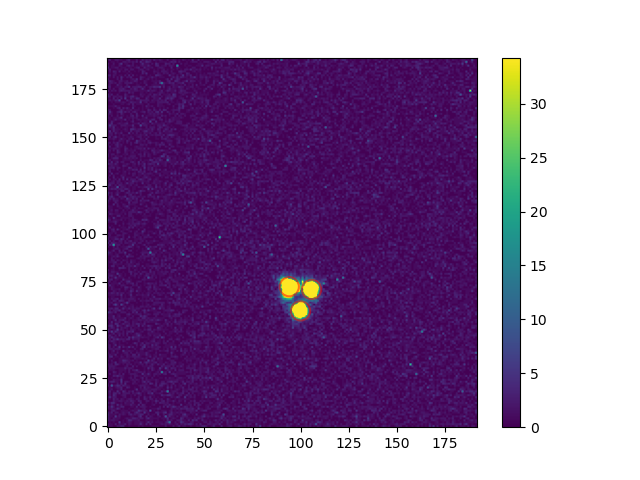

In [106]:
testfile = "/home/tim/MMT/FASS/data/indi_2022-08-29/indi_record_2022-08-29@05-48-58.ser"
ave_seeing, seeing_vals, apertures, fig = analyze_dimm_cube(testfile)
ave_seeing

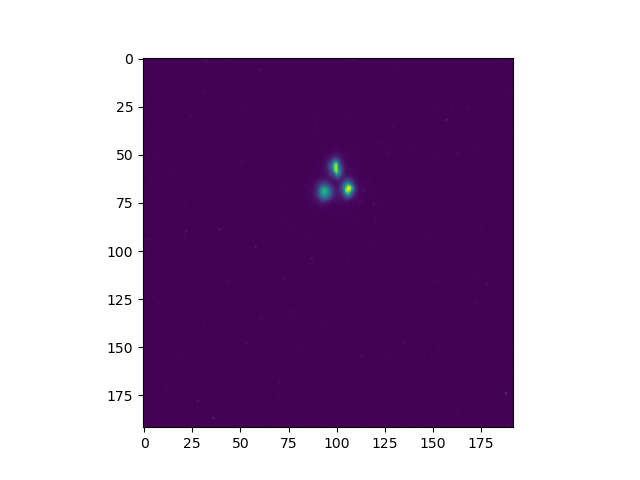

In [4]:
plt.imshow(d['data'][0:50, :, :].sum(axis=0))
#plt.imshow(d['data'][2, :, :]) # - d['data'][0, :, :])
plt.show()

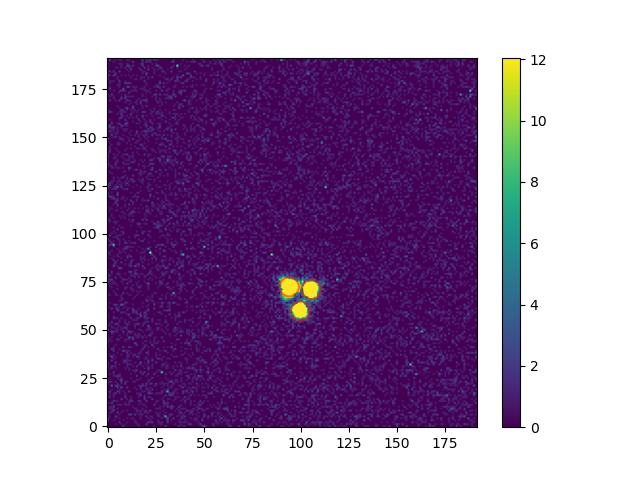

In [31]:
a, fig = find_apertures(d['data'][0:1, :, :].sum(axis=0), plot=True)

In [49]:
a.r

5.0

In [35]:
s = photutils.ApertureStats(d['data'][0, :, :], a)

In [50]:
pos = s.centroid
pos

array([[105.49335548,  70.96137874],
       [ 99.81157708,  59.82988777],
       [ 94.22289157,  72.20401606]])

In [39]:
a2 = photutils.CircularAperture(s.centroid, r=5)
a2

<CircularAperture([[105.49335548,  70.96137874],
                 [ 99.81157708,  59.82988777],
                 [ 94.22289157,  72.20401606]], r=5.0)>

In [64]:
def dimm_calc(data, aps):
    s = photutils.ApertureStats(data, aps)
    ap_pos = s.centroid
    new_aps = photutils.CircularAperture(ap_pos, aps.r)
    base1 = ap_pos[1] - ap_pos[0]
    base2 = ap_pos[2] - ap_pos[0]
    base3 = ap_pos[2] - ap_pos[1]
    d_base1 = np.sqrt(np.dot(base1.T, base1))
    d_base2 = np.sqrt(np.dot(base2.T, base2))
    d_base3 = np.sqrt(np.dot(base3.T, base3))
    return new_aps, [d_base1, d_base2, d_base3]

In [65]:

dimm_calc(d['data'][0, :, :], a)

(<CircularAperture([[105.7854512 ,  70.38167587],
                  [100.10680272,  59.31564626],
                  [ 94.41117851,  71.43934142]], r=5.0)>,
 [12.438008682327906, 11.42334169926124, 13.394928874611411])

In [66]:
nframes = d['data'].shape[0]
nframes

16108

In [67]:
baselines = []
for i in range(nframes):
    a, b = dimm_calc(d['data'][i, :, :], a)
    baselines.append(b)

In [71]:
baselines = np.array(baselines).transpose()

In [76]:
seeing(baselines[0].std()), seeing(baselines[1].std()), seeing(baselines[2].std())

(<Quantity 2.01034187 arcsec>,
 <Quantity 1.91497594 arcsec>,
 <Quantity 2.01094171 arcsec>)

In [79]:
for b in baselines:
    print(b.shape)

(16108,)
(16108,)
(16108,)


In [83]:
l = [1 * u.arcsec, 2 * u.arcsec]

In [86]:
np.mean(u.Quantity(l))

<Quantity 1.5 arcsec>